# Basic Text Classification with Naive Bayes
***
In the mini-project, you'll learn the basics of text analysis using a subset of movie reviews from the rotten tomatoes database. You'll also use a fundamental technique in Bayesian inference, called Naive Bayes. This mini-project is based on [Lab 10 of Harvard's CS109](https://github.com/cs109/2015lab10) class.  Please free to go to the original lab for additional exercises and solutions.

In [11]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

# Table of Contents

* [Rotten Tomatoes Dataset](#Rotten-Tomatoes-Dataset)
    * [Explore](#Explore)
* [The Vector Space Model and a Search Engine](#The-Vector-Space-Model-and-a-Search-Engine)
    * [In Code](#In-Code)
* [Naive Bayes](#Naive-Bayes)
    * [Multinomial Naive Bayes and Other Likelihood Functions](#Multinomial-Naive-Bayes-and-Other-Likelihood-Functions)
    * [Picking Hyperparameters for Naive Bayes and Text Maintenance](#Picking-Hyperparameters-for-Naive-Bayes-and-Text-Maintenance)
* [Interpretation](#Interpretation)


## Rotten Tomatoes Dataset

In [12]:
critics = pd.read_csv('./critics.csv')
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15561 entries, 1 to 27616
Data columns (total 8 columns):
critic         14792 non-null object
fresh          15561 non-null object
imdb           15561 non-null int64
publication    15561 non-null object
quote          15561 non-null object
review_date    15561 non-null object
rtid           15561 non-null int64
title          15561 non-null object
dtypes: int64(2), object(6)
memory usage: 1.1+ MB


In [3]:
critics[['fresh', 'quote']]

,fresh,quote
1,fresh,"So ingenious in concept, design and execution ..."
2,fresh,The year's most inventive comedy.
3,fresh,A winning animated feature that has something ...
4,fresh,The film sports a provocative and appealing st...
5,fresh,"An entertaining computer-generated, hyperreali..."
6,fresh,"As Lion King did before it, Toy Story revived ..."
7,fresh,The film will probably be more fully appreciat...
8,fresh,Children will enjoy a new take on the irresist...
9,fresh,Although its computer-generated imagery is imp...
10,fresh,How perfect that two of the most popular funny...


### Explore

In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


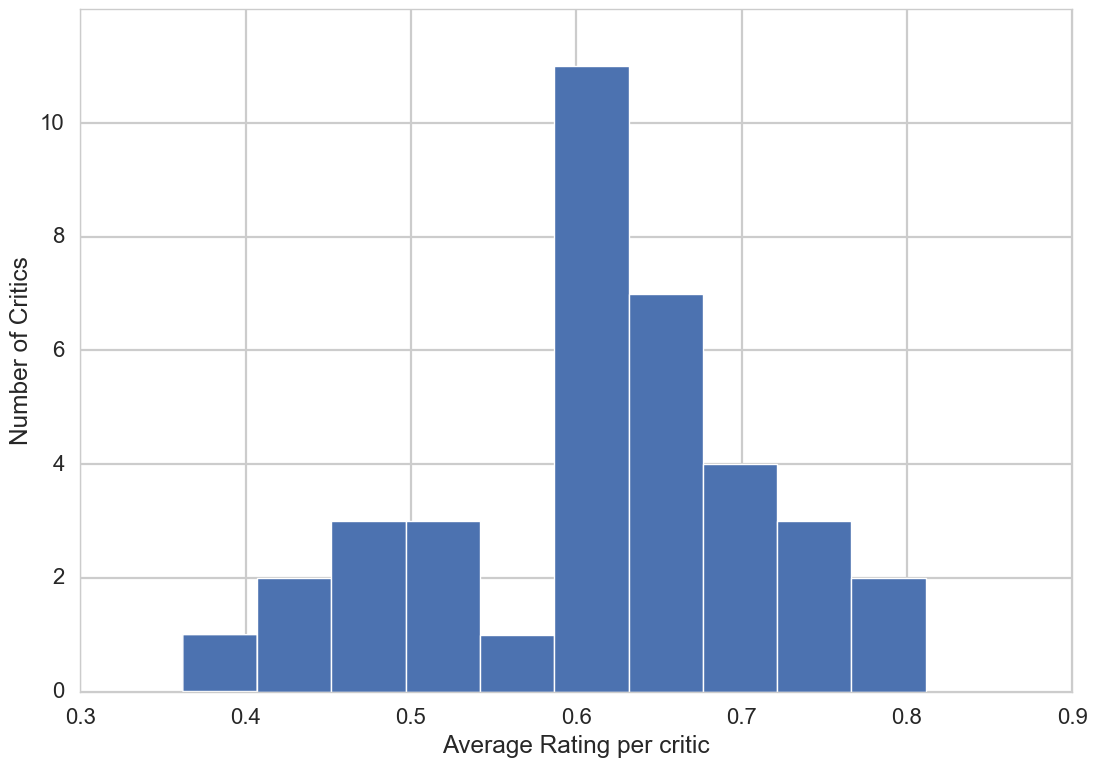

In [3]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [11]:
df

,critic,fresh,imdb,publication,quote,review_date,rtid,title
1,Derek Adams,True,114709,Time Out,"So ingenious in concept, design and execution ...",2009-10-04,9559,Toy story
2,Richard Corliss,True,114709,TIME Magazine,The year's most inventive comedy.,2008-08-31,9559,Toy story
3,David Ansen,True,114709,Newsweek,A winning animated feature that has something ...,2008-08-18,9559,Toy story
4,Leonard Klady,True,114709,Variety,The film sports a provocative and appealing st...,2008-06-09,9559,Toy story
5,Jonathan Rosenbaum,True,114709,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10,9559,Toy story
6,Michael Booth,True,114709,Denver Post,"As Lion King did before it, Toy Story revived ...",2007-05-03,9559,Toy story
7,Geoff Andrew,True,114709,Time Out,The film will probably be more fully appreciat...,2006-06-24,9559,Toy story
8,Janet Maslin,True,114709,New York Times,Children will enjoy a new take on the irresist...,2003-05-20,9559,Toy story
9,Kenneth Turan,True,114709,Los Angeles Times,Although its computer-generated imagery is imp...,2001-02-13,9559,Toy story
10,Susan Wloszczyna,True,114709,USA Today,How perfect that two of the most popular funny...,2000-01-01,9559,Toy story


<div class="span5 alert alert-info">
<h3>Exercise Set I</h3>
<br/>
<b>Exercise:</b> Look at the histogram above. Tell a story about the average ratings per critic. What shape does the distribution look like? What is interesting about the distribution? What might explain these interesting things?
</div>

There is a bimodal distribution of the average ratings per critic. 
It seems that there is a small cluster of critics that are more critical and giving significantly below average reviews, while the majority of reviews center between 0.6 and 0.7 in rating.

## The Vector Space Model and a Search Engine

All the diagrams here are snipped from [*Introduction to Information Retrieval* by Manning et. al.]( http://nlp.stanford.edu/IR-book/) which is a great resource on text processing. For additional information on text mining and natural language processing, see [*Foundations of Statistical Natural Language Processing* by Manning and Schutze](http://nlp.stanford.edu/fsnlp/).

Also check out Python packages [`nltk`](http://www.nltk.org/), [`spaCy`](https://spacy.io/), [`pattern`](http://www.clips.ua.ac.be/pattern), and their associated resources. Also see [`word2vec`](https://en.wikipedia.org/wiki/Word2vec).

Let us define the vector derived from document $d$ by $\bar V(d)$. What does this mean? Each document is treated as a vector containing information about the words contained in it. Each vector has the same length and each entry "slot" in the vector contains some kind of data about the words that appear in the document such as presence/absence (1/0), count (an integer) or some other statistic. Each vector has the same length because each document shared the same vocabulary across the full collection of documents -- this collection is called a *corpus*.

To define the vocabulary, we take a union of all words we have seen in all documents. We then just associate an array index with them. So "hello" may be at index 5 and "world" at index 99.

Suppose we have the following corpus:

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree. The grapes seemed ready to burst with juice, and the Fox's mouth watered as he gazed longingly at them.`

Suppose we treat each sentence as a document $d$. The vocabulary (often called the *lexicon*) is the following:

$V = \left\{\right.$ `a, along, and, as, at, beautiful, branches, bunch, burst, day, fox, fox's, from, gazed, grapes, hanging, he, juice, longingly, mouth, of, one, ready, ripe, seemed, spied, the, them, to, trained, tree, vine, watered, with`$\left.\right\}$

Then the document

`A Fox one day spied a beautiful bunch of ripe grapes hanging from a vine trained along the branches of a tree`

may be represented as the following sparse vector of word counts:

$$\bar V(d) = \left( 4,1,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,0,2,1,0,1,0,0,1,0,0,0,1,1,0,0 \right)$$

or more succinctly as

`[(0, 4), (1, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (12, 1), (14, 1), (15, 1), (20, 2), (21, 1), (23, 1),`
`(26, 1), (30, 1), (31, 1)]`

along with a dictionary

``
{
    0: a, 1: along, 5: beautiful, 6: branches, 7: bunch, 9: day, 10: fox, 12: from, 14: grapes, 
    15: hanging, 19: mouth, 20: of, 21: one, 23: ripe, 24: seemed, 25: spied, 26: the, 
    30: tree, 31: vine, 
}
``

Then, a set of documents becomes, in the usual `sklearn` style, a sparse matrix with rows being sparse arrays representing documents and columns representing the features/words in the vocabulary.

Notice that this representation loses the relative ordering of the terms in the document. That is "cat ate rat" and "rat ate cat" are the same. Thus, this representation is also known as the Bag-Of-Words representation.

Here is another example, from the book quoted above, although the matrix is transposed here so that documents are columns:

![novel terms](terms.png)

Such a matrix is also catted a Term-Document Matrix. Here, the terms being indexed could be stemmed before indexing; for instance, `jealous` and `jealousy` after stemming are the same feature. One could also make use of other "Natural Language Processing" transformations in constructing the vocabulary. We could use Lemmatization, which reduces words to lemmas: work, working, worked would all reduce to work. We could remove "stopwords" from our vocabulary, such as common words like "the". We could look for particular parts of speech, such as adjectives. This is often done in Sentiment Analysis. And so on. It all depends on our application.

From the book:
>The standard way of quantifying the similarity between two documents $d_1$ and $d_2$  is to compute the cosine similarity of their vector representations $\bar V(d_1)$ and $\bar V(d_2)$:

$$S_{12} = \frac{\bar V(d_1) \cdot \bar V(d_2)}{|\bar V(d_1)| \times |\bar V(d_2)|}$$

![Vector Space Model](vsm.png)


>There is a far more compelling reason to represent documents as vectors: we can also view a query as a vector. Consider the query q = jealous gossip. This query turns into the unit vector $\bar V(q)$ = (0, 0.707, 0.707) on the three coordinates below. 

![novel terms](terms2.png)

>The key idea now: to assign to each document d a score equal to the dot product:

$$\bar V(q) \cdot \bar V(d)$$

Then we can use this simple Vector Model as a Search engine.

### In Code

In [16]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))

# `get_feature_names` tracks which word is associated with each column of the transformed x
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names())

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop', 'off', 'on', 'pop']


In [17]:
def make_xy(critics, vectorizer=None):
    #Your code here    
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(np.int)
    return X, y
X, y = make_xy(critics)

In [18]:
X.shape # there are 15561 features, each with 22417 words

(15561, 22417)

## Naive Bayes

From Bayes' Theorem, we have that

$$P(c \vert f) = \frac{P(c \cap f)}{P(f)}$$

where $c$ represents a *class* or category, and $f$ represents a feature vector, such as $\bar V(d)$ as above. **We are computing the probability that a document (or whatever we are classifying) belongs to category *c* given the features in the document.** $P(f)$ is really just a normalization constant, so the literature usually writes Bayes' Theorem in context of Naive Bayes as

$$P(c \vert f) \propto P(f \vert c) P(c) $$

$P(c)$ is called the *prior* and is simply the probability of seeing class $c$. But what is $P(f \vert c)$? This is the probability that we see feature set $f$ given that this document is actually in class $c$. This is called the *likelihood* and comes from the data. One of the major assumptions of the Naive Bayes model is that the features are *conditionally independent* given the class. While the presence of a particular discriminative word may uniquely identify the document as being part of class $c$ and thus violate general feature independence, conditional independence means that the presence of that term is independent of all the other words that appear *within that class*. This is a very important distinction. Recall that if two events are independent, then:

$$P(A \cap B) = P(A) \cdot P(B)$$

Thus, conditional independence implies

$$P(f \vert c)  = \prod_i P(f_i | c) $$

where $f_i$ is an individual feature (a word in this example).

To make a classification, we then choose the class $c$ such that $P(c \vert f)$ is maximal.

There is a small caveat when computing these probabilities. For [floating point underflow](http://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html) we change the product into a sum by going into log space. This is called the LogSumExp trick. So:

$$\log P(f \vert c)  = \sum_i \log P(f_i \vert c) $$

There is another caveat. What if we see a term that didn't exist in the training data? This means that $P(f_i \vert c) = 0$ for that term, and thus $P(f \vert c)  = \prod_i P(f_i | c) = 0$, which doesn't help us at all. Instead of using zeros, we add a small negligible value called $\alpha$ to each count. This is called Laplace Smoothing.

$$P(f_i \vert c) = \frac{N_{ic}+\alpha}{N_c + \alpha N_i}$$

where $N_{ic}$ is the number of times feature $i$ was seen in class $c$, $N_c$ is the number of times class $c$ was seen and $N_i$ is the number of times feature $i$ was seen globally. $\alpha$ is sometimes called a regularization parameter.

### Multinomial Naive Bayes and Other Likelihood Functions

Since we are modeling word counts, we are using variation of Naive Bayes called Multinomial Naive Bayes. This is because the likelihood function actually takes the form of the multinomial distribution.

$$P(f \vert c) = \frac{\left( \sum_i f_i \right)!}{\prod_i f_i!} \prod_{f_i} P(f_i \vert c)^{f_i} \propto \prod_{i} P(f_i \vert c)$$

where the nasty term out front is absorbed as a normalization constant such that probabilities sum to 1.

There are many other variations of Naive Bayes, all which depend on what type of value $f_i$ takes. If $f_i$ is continuous, we may be able to use *Gaussian Naive Bayes*. First compute the mean and variance for each class $c$. Then the likelihood, $P(f \vert c)$ is given as follows

$$P(f_i = v \vert c) = \frac{1}{\sqrt{2\pi \sigma^2_c}} e^{- \frac{\left( v - \mu_c \right)^2}{2 \sigma^2_c}}$$

<div class="span5 alert alert-info">
<h3>Exercise Set II</h3>

<p><b>Exercise:</b> Implement a simple Naive Bayes classifier:</p>

<ol>
<li> split the data set into a training and test set
<li> Use `scikit-learn`'s `MultinomialNB()` classifier with default parameters.
<li> train the classifier over the training set and test on the test set
<li> print the accuracy scores for both the training and the test sets
</ol>

What do you notice? Is this a good classifier? If not, why not?
</div>

In [6]:
#split the data set into a training and test set
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)


/Users/yizhao/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
#Use scikit-learn's MultinomialNB() classifier with default parameters
from sklearn.naive_bayes import MultinomialNB

#train the classifier over the training set and test on the test set
NB = MultinomialNB()
NB.fit(Xtrain, ytrain)
y_pred = NB.predict(Xtest)

# print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score
print('Train accuracy: ',accuracy_score(NB.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.922107969152
Test accuracy:  0.77589308661


#### The train accuracy is much higher than the test accuracy at 92.2% compared to the 77.6% in the testing set. This is expected, but there is still a lot of potential for improving the test accuracy and a big difference between the training and testing accuracy may indicate that we have overfitted the model. 
#### A high accuracy score may sound good at first, but it doesn't necessarily mean that we have a good classifier. This very much depends on the distribution of our actual labels. For instance, if 90% of the labels are 1 and 10% are labeled 0 in a binary variable, a 77% accuracy rate may be terrible at predicting the true 0 labels, which may be what is the most important to us. 


### Picking Hyperparameters for Naive Bayes and Text Maintenance

We need to know what value to use for $\alpha$, and we also need to know which words to include in the vocabulary. As mentioned earlier, some words are obvious stopwords. Other words appear so infrequently that they serve as noise, and other words in addition to stopwords appear so frequently that they may also serve as noise.

First, let's find an appropriate value for `min_df` for the `CountVectorizer`. `min_df` can be either an integer or a float/decimal. If it is an integer, `min_df` represents the minimum number of documents a word must appear in for it to be included in the vocabulary. If it is a float, it represents the minimum *percentage* of documents a word must appear in to be included in the vocabulary. From the documentation:

>min_df: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

<div class="span5 alert alert-info">
<h3>Exercise Set III</h3>

<p><b>Exercise:</b> Construct the cumulative distribution of document frequencies (df). The $x$-axis is a document count $x_i$ and the $y$-axis is the percentage of words that appear less than $x_i$ times. For example, at $x=5$, plot a point representing the percentage or number of words that appear in 5 or fewer documents.</p>

<p><b>Exercise:</b> Look for the point at which the curve begins climbing steeply. This may be a good value for `min_df`. If we were interested in also picking `max_df`, we would likely pick the value where the curve starts to plateau. What value did you choose?</p>
</div>

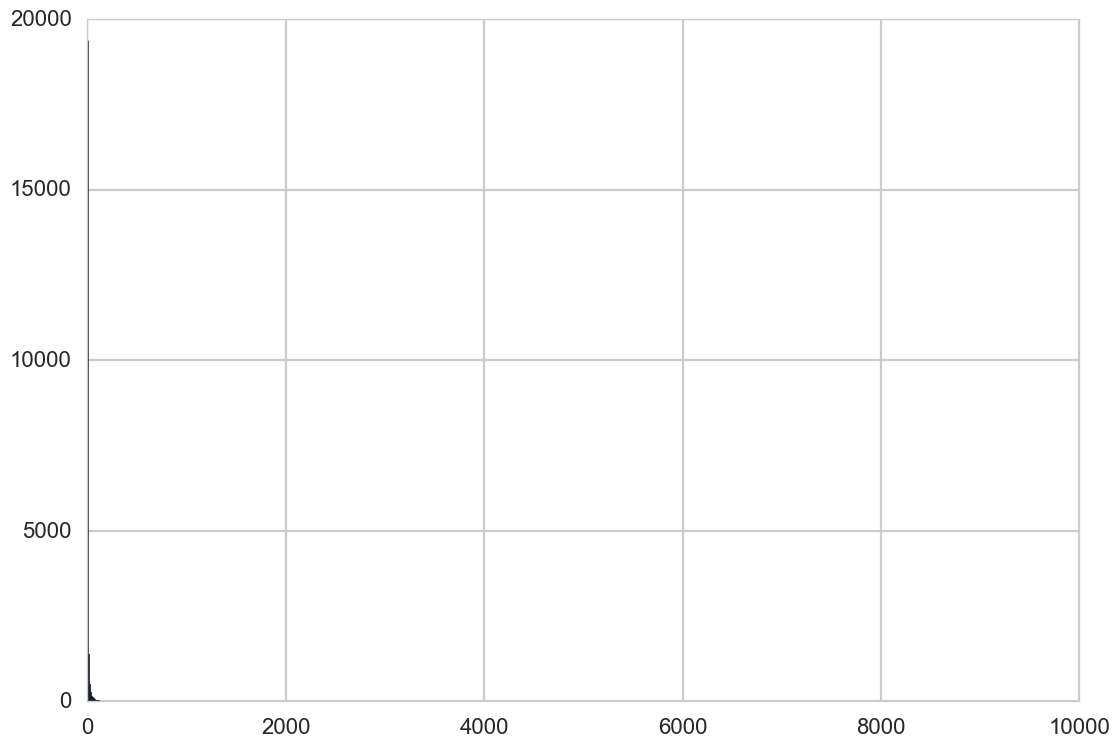

In [23]:
df = list(  sorted(  # sum the total number of occurences of each word (along axis 0) 
        #for those that are above 0 
                    (X > 0).sum(axis=0).reshape( # convert into a one dimensional array
                                                -1).tolist()[0]
        # it is a list with only one element, so get just the first element
                    ) # sort the counts
         )
plt.hist(df, bins= 1000)
plt.show()

In [24]:
# define the total number of observations and the number of unique words, or features
rows, features = X.shape

# compute the histogram of the dataset using the number of bins as exactly 
# the same number of unique occurences of words
height, axis = np.histogram(df, bins=len(np.unique(df)))
print(height, '\n\n', axis)
# height is the total number of words(features) with a corresponding axis value of word counts
# for instance, there are 21347 words that occured only once in all of the documents.

[21347   537   179    96    44    36    27    24    23    12     8     7
     6     7     4     4     2     3     1     4     1     5     3     0
     1     2     0     2     0     0     0     3     1     2     2     1
     0     0     1     0     2     1     0     2     0     0     0     0
     0     0     0     0     0     0     1     0     0     1     0     0
     0     0     0     0     1     1     0     0     0     0     1     0
     1     0     1     0     0     2     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     1     0     0     0     0     0     0     0     0     0     0     0
     0     1     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     1   

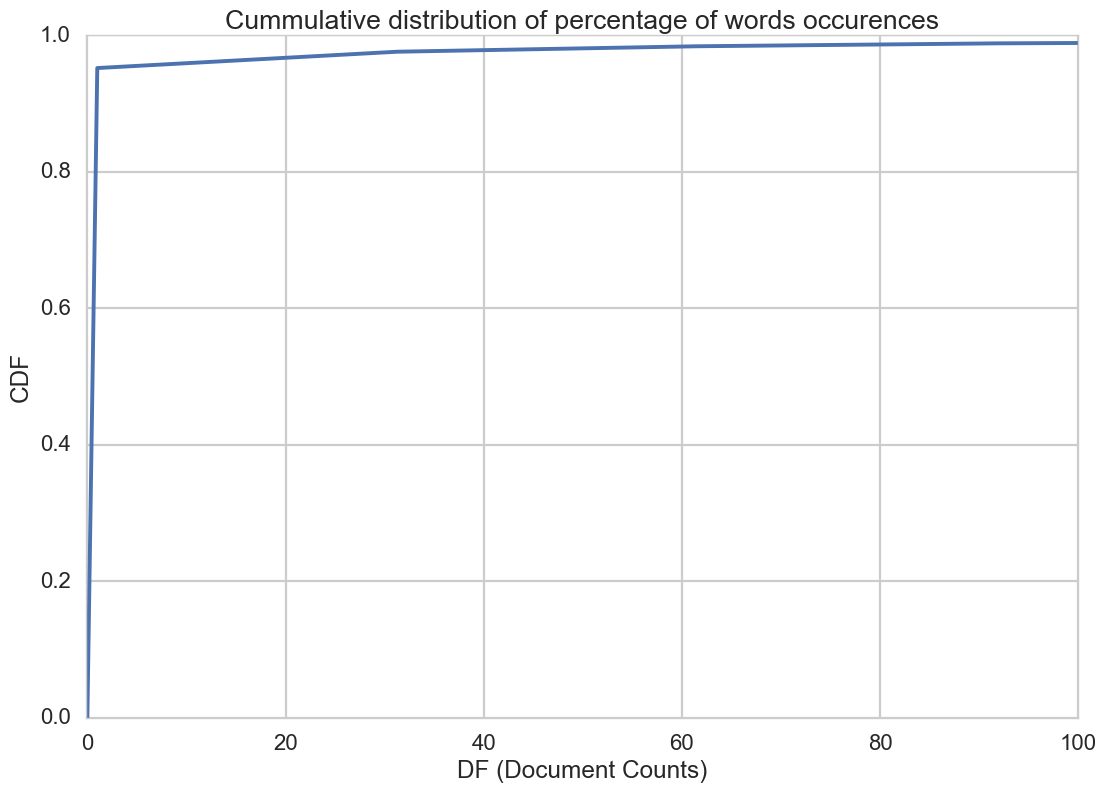

In [25]:
# create a cummulative sum of the word count and normalize by the total number of unique words
cumhist = np.cumsum(height * 1, axis=0) / features

# add a couple of zeros into the x and y axis of the cummulative distribution plot
axis = np.insert(axis, 0, 0)
cumhist = np.insert(cumhist, 0, 0)

#
plt.plot(axis[:-1], cumhist)
plt.xlim(-.1, 100)
plt.xlabel("DF (Document Counts)")
plt.ylabel("CDF")
plt.title("Cummulative distribution of percentage of words occurences")

#### The started to climb steeply at 5 total occurences in documents. So a good value for min_df would be 5. Also, the curve starts to plateau at 30, or as the elbow point in this curve. So I would choose 30 for max_df.

The parameter $\alpha$ is chosen to be a small value that simply avoids having zeros in the probability computations. This value can sometimes be chosen arbitrarily with domain expertise, but we will use K-fold cross validation. In K-fold cross-validation, we divide the data into $K$ non-overlapping parts. We train on $K-1$ of the folds and test on the remaining fold. We then iterate, so that each fold serves as the test fold exactly once. The function `cv_score` performs the K-fold cross-validation algorithm for us, but we need to pass a function that measures the performance of the algorithm on each fold. 

In [26]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

We use the log-likelihood as the score here in `scorefunc`. The higher the log-likelihood, the better. Indeed, what we do in `cv_score` above is to implement the cross-validation part of `GridSearchCV`.

The custom scoring function `scorefunc` allows us to use different metrics depending on the decision risk we care about (precision, accuracy, profit etc.) directly on the validation set. You will often find people using `roc_auc`, precision, recall, or `F1-score` as the scoring function.

In [27]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

We'll cross-validate over the regularization parameter $\alpha$.

Let's set up the train and test masks first, and then we can run the cross-validation procedure.

In [28]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=np.bool)
mask[itest] = True

<div class="span5 alert alert-info">
<h3>Exercise Set IV</h3>

<p><b>Exercise:</b> What does using the function `log_likelihood` as the score mean? What are we trying to optimize for?</p>

<p><b>Exercise:</b> Without writing any code, what do you think would happen if you choose a value of $\alpha$ that is too high?</p>

<p><b>Exercise:</b> Using the skeleton code below, find the best values of the parameter `alpha`, and use the value of `min_df` you chose in the previous exercise set. Use the `cv_score` function above with the `log_likelihood` function for scoring.</p>
</div>

Log_likelihood is a score indicative of the probability of a value being 1. We are optimizing for the most number of correct estimationg of test set y values.
If alpha is too high, we would over penalize for the sparcity of the matrix and give too much weight to the otherwise 0 count words. In other words, zero counts may be falsly classified as real counts such that the performance of our model worsens.

In [36]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over
alphas = [.05,.1,1, 5, 10, 50]
best_min_df = 5

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
maxscore=-np.inf
scores = []

for alpha in alphas:        
    vectorizer = CountVectorizer(min_df=best_min_df)       
    Xthis, ythis = make_xy(critics, vectorizer)
    Xtrainthis = Xthis[mask]
    ytrainthis = ythis[mask]
    temp_score = cv_score(clf= MultinomialNB(alpha = alpha),
                             scorefunc=log_likelihood,
                             X = Xtrainthis,
                             y = ytrainthis
                            )
    if temp_score > maxscore:
        maxscore = temp_score
        best_alpha = alpha
    scores.append((alpha, temp_score))
scores

[(0.05, -1042.4577386960693),
 (0.1, -903.2324051205469),
 (1, -593.95537943053455),
 (5, -718.77567973906866),
 (10, -946.67174632692843),
 (50, -1231.4458911593906)]

In [37]:
print("alpha: {}".format(best_alpha))

alpha: 1


<div class="span5 alert alert-info">
<h3>Exercise Set V: Working with the Best Parameters</h3>

<p><b>Exercise:</b> Using the best value of  `alpha` you just found, calculate the accuracy on the training and test sets. Is this classifier better? Why (not)?</p>

</div>

In [38]:
vectorizer = CountVectorizer(min_df= best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.906832
Accuracy on test data:     0.742380


In [39]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2622 1647]
 [1159 5464]]


## Interpretation

### What are the strongly predictive features?

We use a neat trick to identify strongly predictive features (i.e. words). 

* first, create a data set such that each row has exactly one feature. This is represented by the identity matrix.
* use the trained classifier to make predictions on this matrix
* sort the rows by predicted probabilities, and pick the top and bottom $K$ rows

In [133]:
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))
    
print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
                most 0.77
                 one 0.70
                 his 0.69
                film 0.68
                with 0.67
                 has 0.66
                  an 0.65
                 and 0.65
                  of 0.64
                  in 0.63
Bad words	     P(fresh | word)
                 all 0.57
                than 0.57
                 but 0.56
                  to 0.55
                this 0.55
                 are 0.55
                more 0.53
                have 0.51
                  be 0.50
                like 0.48


<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Why does this method work? What does the probability for each row in the identity matrix represent</p>

</div>

#### The identity matrix means using only one word per observation to predict a log likelihood probability of the previously trained multinobial niave bayes model. The probability shows how likely a word is to make a particular review fresh or rotten. The higher the probability, the more likely that the predicted value was to be categorizes as 1. 

The above exercise is an example of *feature selection*. There are many other feature selection methods. A list of feature selection methods available in `sklearn` is [here](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection). The most common feature selection technique for text mining is the chi-squared $\left( \chi^2 \right)$ [method](http://nlp.stanford.edu/IR-book/html/htmledition/feature-selectionchi2-feature-selection-1.html).

### Prediction Errors

We can see mis-predictions as well.

In [134]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
Take away a couple of neatly staged action sequences and you're left with a callously measured slab of US jingoism that deals with the most horrific human tragedies in the most lunk-headed and insulting way possible.

Nava, who started his feature-film career with El Norte, is a good director who invariably finds a strong rapport with his actors. He's not much of a writer, though, and he should think twice about creating dialogue for his future projects.

One seemingly terminal problem with the casting of Ms. Aniston and Mr. Vaughn is that neither of their careers has featured characters who excelled at one-to-one relationships with the opposite sex.

It survives today only as an unusually pure example of a typical 50s art-film strategy: the attempt to make the most modern and most popular of art forms acceptable to the intelligentsia by forcing it into an arcane, antique mold.

This is both the movie in which [Russell] is most fa

<div class="span5 alert alert-info">
<h3>Exercise Set VII: Predicting the Freshness for a New Review</h3>
<br/>
<div>
<b>Exercise:</b>
<ul>
<li> Using your best trained classifier, predict the freshness of the following sentence: *'This movie is not remarkable, touching, or superb in any way'*
<li> Is the result what you'd expect? Why (not)?
</ul>
</div>
</div>

In [40]:
# test with the new quote
new_review = 'This movie is not remarkable, touching, or superb in any way'

Xquery = vectorizer.transform([new_review])
print(clf.predict_proba(Xquery))

[[ 0.00437824  0.99562176]]


#### The prediction says that there is a 99.6% probability for this quote to be fresh. However, this prediction is wrong. 
#### This is because we didn't take into account negation or the combination of words in the predictions. Since the majority of words in this quote are positive, we received a 'fresh' prediction, despite of its 'not' made it a 'rotten' one.

### Aside: TF-IDF Weighting for Term Importance

TF-IDF stands for 

`Term-Frequency X Inverse Document Frequency`.

In the standard `CountVectorizer` model above, we used just the term frequency in a document of words in our vocabulary. In TF-IDF, we weight this term frequency by the inverse of its popularity in all documents. For example, if the word "movie" showed up in all the documents, it would not have much predictive value. It could actually be considered a stopword. By weighing its counts by 1 divided by its overall frequency, we downweight it. We can then use this TF-IDF weighted features as inputs to any classifier. **TF-IDF is essentially a measure of term importance, and of how discriminative a word is in a corpus.** There are a variety of nuances involved in computing TF-IDF, mainly involving where to add the smoothing term to avoid division by 0, or log of 0 errors. The formula for TF-IDF in `scikit-learn` differs from that of most textbooks: 

$$\mbox{TF-IDF}(t, d) = \mbox{TF}(t, d)\times \mbox{IDF}(t) = n_{td} \log{\left( \frac{\vert D \vert}{\vert d : t \in d \vert} + 1 \right)}$$

where $n_{td}$ is the number of times term $t$ occurs in document $d$, $\vert D \vert$ is the number of documents, and $\vert d : t \in d \vert$ is the number of documents that contain $t$

In [152]:
# http://scikit-learn.org/dev/modules/feature_extraction.html#text-feature-extraction
# http://scikit-learn.org/dev/modules/classes.html#text-feature-extraction-ref
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)



<div class="span5 alert alert-info">
<h3>Exercise Set VIII: Enrichment</h3>

<p>
There are several additional things we could try. Try some of these as exercises:
<ol>
<li> Build a Naive Bayes model where the features are n-grams instead of words. N-grams are phrases containing n words next to each other: a bigram contains 2 words, a trigram contains 3 words, and 6-gram contains 6 words. This is useful because "not good" and "so good" mean very different things. On the other hand, as n increases, the model does not scale well since the feature set becomes more sparse.
<li> Try a model besides Naive Bayes, one that would allow for interactions between words -- for example, a Random Forest classifier.
<li> Try adding supplemental features -- information about genre, director, cast, etc.
<li> Use word2vec or [Latent Dirichlet Allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) to group words into topics and use those topics for prediction.
<li> Use TF-IDF weighting instead of word counts.
</ol>
</p>

<b>Exercise:</b> Try a few of these ideas to improve the model (or any other ideas of your own). Implement here and report on the result.
</div>

### 1. Try n-gram

In [151]:
# create a countvectorizer object with ngram
ngram = CountVectorizer(ngram_range=(1,2)) # up to two words

# reorganize the orignial data into array form
X = ngram.fit_transform(critics.quote)
X = X.tocsc()  # some versions of sklearn return COO format
y = (critics.fresh == 'fresh').values.astype(np.int)

# split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# build a Naive Bayes model
NB = MultinomialNB()
NB.fit(Xtrain, ytrain)
y_pred = NB.predict(Xtest)

# print the accuracy scores for both the training and the test sets
print('Train accuracy: ',accuracy_score(NB.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.991688089117
Test accuracy:  0.770496016448


### 2. Random forest model

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [179]:
# build a Random Forest model
RF = RandomForestClassifier(n_estimators= 20, min_impurity_split=1e-02)
RF.fit(Xtrain, ytrain)
y_pred = RF.predict(Xtest)

In [180]:
# print the accuracy scores for both the training and the test sets
print('Train accuracy: ',accuracy_score(RF.predict(Xtrain), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.998971722365
Test accuracy:  0.690824980725


### 4 & 5. LDA for topic extraction and Tfid

In [10]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups
 
n_features = 1000 # input in to the tfidf function
n_topics = 10 # input into the LDA function
n_top_words = 20 # number of top words to print in a topic


def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

# split the data
y = (critics.fresh == 'fresh').values.astype(np.int)
Xtrain, Xtest, ytrain, ytest = train_test_split(critics.quote, y)


# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(Xtrain)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(Xtrain)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      " n_features=%d..."
      % ( n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, "
      "n_features=%d..."
      % ( n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 0.612s.
Extracting tf features for LDA...
done in 0.354s.
Fitting the NMF model with tf-idf features, n_samples=2000 and n_features=1000...
done in 0.456s.

Topics in NMF model:
Topic #0:
movie kind isn action way little make big just great does doesn time horror makes moments sense tv lot know
Topic #1:
film great director american new make doesn way characters sense work does humor end action long performance makes style little
Topic #2:
like just movies feels looks makes make watching characters feel don look life doesn man little ve director plays new
Topic #3:
funny smart scary fast touching satire don just moving clever pretty frequently jokes isn dark warm laughs consistently aren humor
Topic #4:
good time bad isn feel acting pretty performances just great makes better way make entertainment job looks long humor things
Topic #5:
comedy romantic romance black american spirited high laughs drama little attempt love teen melodrama actio

In [11]:
lda_topics = lda.fit_transform(tf)

#Use scikit-learn's MultinomialNB() classifier with default parameters
from sklearn.naive_bayes import MultinomialNB

#train the classifier over the training set and test on the test set
NB = MultinomialNB()
NB.fit(lda_topics, ytrain)

tf_test = tf_vectorizer.fit_transform(Xtest)
lda_test = lda.fit_transform(tf_test)
y_pred = NB.predict(lda_test)

# print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score
print('Train accuracy: ',accuracy_score(NB.predict(lda_topics), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.610625535561
Test accuracy:  0.605499871498


In [12]:
tfidf_test = tfidf_vectorizer.fit_transform(Xtest)
NB.fit(tfidf, ytrain)

tfidf_test = tf_vectorizer.fit_transform(Xtest)
y_pred = NB.predict(tfidf_test)

# print the accuracy scores for both the training and the test sets
from sklearn.metrics import accuracy_score
print('Train accuracy: ',accuracy_score(NB.predict(tfidf), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.737617823479
Test accuracy:  0.526342842457


In [17]:
# build a Random Forest model
RF = RandomForestClassifier(n_estimators= 100)
RF.fit(lda_topics, ytrain)
y_pred = RF.predict(lda_test)

# print the accuracy scores for both the training and the test sets
print('Train accuracy: ',accuracy_score(RF.predict(lda_topics), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.953641816624
Test accuracy:  0.565407350296


In [18]:
# build a Random Forest model
RF = RandomForestClassifier(n_estimators= 100)
RF.fit(tfidf, ytrain)
y_pred = RF.predict(tfidf_test)

# print the accuracy scores for both the training and the test sets
print('Train accuracy: ',accuracy_score(RF.predict(tfidf), ytrain))
print('Test accuracy: ',accuracy_score(y_pred, ytest))

Train accuracy:  0.979605826907
Test accuracy:  0.452582883577


In [20]:
from sklearn import metrics
print(metrics.classification_report(ytest, y_pred))

             precision    recall  f1-score   support

          0       0.39      0.69      0.50      1535
          1       0.60      0.30      0.40      2356

avg / total       0.51      0.45      0.44      3891



#### Overall, LDA and TFidf didn't really improve the test accuracy. Even though the training accuracy continud to improve, the model is very likely overfitting.